<a href="https://colab.research.google.com/github/Ahillman2000/UFCFSN-15-3-/blob/main/AI_for_CT_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import helper
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torchvision import datasets, transforms

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
!unzip '/content/gdrive/MyDrive/AI/d6.zip' > /dev/null

In [4]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("GPU available")
else:
  print("GPU not available, training on CPU")

GPU available


In [5]:
def DisplayImage(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean 
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

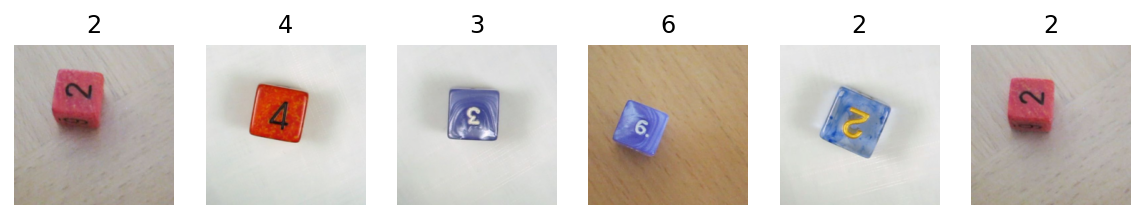

In [6]:
data_dir = 'd6'

batch_size = 6

image_res = 224

display_images = 6

if(display_images > batch_size):
  display_images = batch_size

transform = transforms.Compose([transforms.Resize(image_res),
                                transforms.CenterCrop(image_res),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

test_data  = datasets.ImageFolder(data_dir + '/test', transform=transform)
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data   = datasets.ImageFolder(data_dir + '/validate', transform=transform)

test_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)

data_iter = iter(train_loader)
images, labels = next(data_iter)

#print(labels.shape)

fig, axes = plt.subplots(figsize=(10,display_images), ncols=display_images)
for ii in range(display_images):
    ax = axes[ii]
    DisplayImage(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item() + 1)) 

# Multi Layer Perceptron

torch.Size([10])


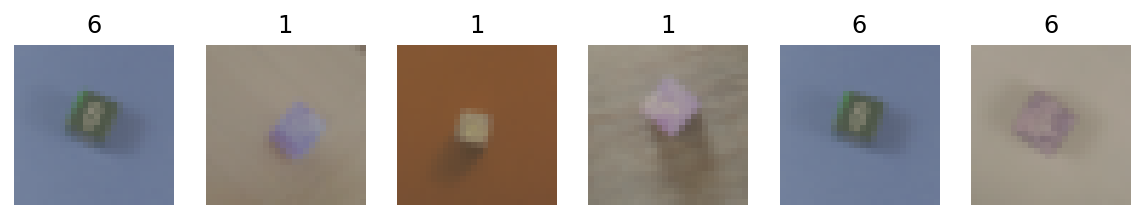

In [7]:
from torchvision import datasets, transforms

data_dir = 'd6'

batch_size = 10

transform = transforms.Compose([transforms.Resize(28),
                                transforms.CenterCrop(28),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])])

test_data  = datasets.ImageFolder(data_dir + '/test', transform=transform)
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data   = datasets.ImageFolder(data_dir + '/validate', transform=transform)

test_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)

data_iter = iter(train_loader)
images, labels = next(data_iter)

print(labels.shape)

fig, axes = plt.subplots(figsize=(10,6), ncols=6)
for ii in range(6):
    ax = axes[ii]
    DisplayImage(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item() + 1)) 

In [8]:
from torch import nn, optim
import torch.nn.functional

n_inputs = 2352

# define the MLP NN
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        hidden_1 = 1028
        hidden_2 = 512
        hidden_3 = 256
        numberOfClasses = 6

        self.fc1 = nn.Linear(n_inputs, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, numberOfClasses) 

        # Dropout module with 0.2 drop probability - to prevent overfitting
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(-1, n_inputs)

        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        x = self.dropout(torch.nn.functional.relu(self.fc2(x)))
        x = self.dropout(torch.nn.functional.relu(self.fc3(x)))


        x = torch.nn.functional.log_softmax(self.fc4(x), dim=1) 
        return x

model = Classifier()
print(model)

Classifier(
  (fc1): Linear(in_features=2352, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [9]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [10]:
epochs = 15

valid_loss_min = np.Inf # set initial "min" to infinity

train_losses, val_losses = [], []

for epoch in range(epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'MLP_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/MLP_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.444545 	Validation Loss: 2.664588
Validation loss decreased (inf --> 2.664588).  Saving model ...
Epoch: 2 	Training Loss: 2.056428 	Validation Loss: 1.702593
Validation loss decreased (2.664588 --> 1.702593).  Saving model ...
Epoch: 3 	Training Loss: 1.642735 	Validation Loss: 1.679882
Validation loss decreased (1.702593 --> 1.679882).  Saving model ...
Epoch: 4 	Training Loss: 1.486538 	Validation Loss: 1.567018
Validation loss decreased (1.679882 --> 1.567018).  Saving model ...
Epoch: 5 	Training Loss: 1.337535 	Validation Loss: 1.666932
Epoch: 6 	Training Loss: 1.000473 	Validation Loss: 2.359075
Epoch: 7 	Training Loss: 0.945904 	Validation Loss: 1.983728
Epoch: 8 	Training Loss: 1.121281 	Validation Loss: 1.766274
Epoch: 9 	Training Loss: 0.759148 	Validation Loss: 2.774735
Epoch: 10 	Training Loss: 0.736444 	Validation Loss: 2.529803
Epoch: 11 	Training Loss: 0.664402 	Validation Loss: 1.985807
Epoch: 12 	Training Loss: 0.608228 	Validation Loss: 3.4

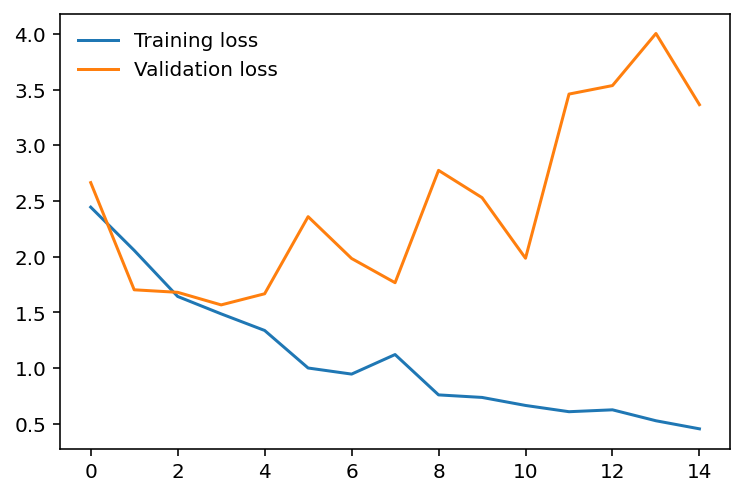

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [12]:
model.load_state_dict(torch.load('MLP_model.pt'))

<All keys matched successfully>

In [13]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.513609

Test Accuracy of     0: 60% (38/63)
Test Accuracy of     1: 35% (13/37)
Test Accuracy of     2: 50% (23/46)
Test Accuracy of     3: 63% (23/36)
Test Accuracy of     4:  0% ( 0/17)
Test Accuracy of     5: 42% (17/40)

Test Accuracy (Overall): 47% (114/239)


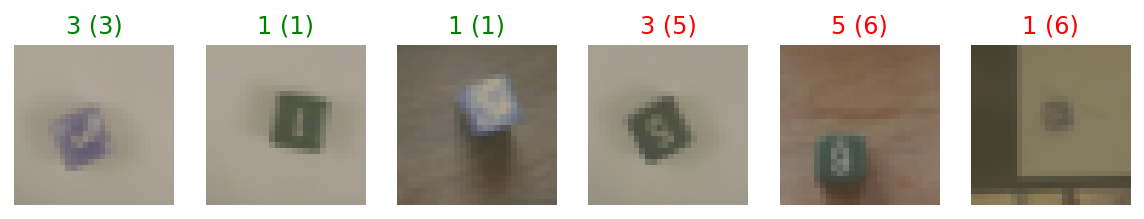

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,6), ncols=6)
for ii in range(6):
    ax = axes[ii]
    DisplayImage(images[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item() + 1), str(labels[ii].item() + 1)),
                 color=("green" if preds[ii]==labels[ii] else "red")) 

# 0 is good, 1 is poor
# 1st is predicted class, 2nd is actual class

#Convolusional Neural Network

torch.Size([6])


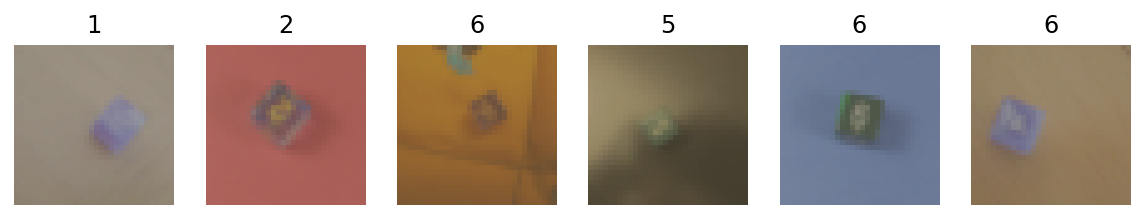

In [15]:
data_dir = 'd6'

batch_size = 6

image_res = 32

display_images = 6

if(display_images > batch_size):
  display_images = batch_size

transform = transforms.Compose([transforms.Resize(image_res),
                                transforms.CenterCrop(image_res),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])])

test_data  = datasets.ImageFolder(data_dir + '/test', transform=transform)
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data   = datasets.ImageFolder(data_dir + '/validate', transform=transform)

test_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)

data_iter = iter(train_loader)
images, labels = next(data_iter)

print(labels.shape)

fig, axes = plt.subplots(figsize=(10,display_images), ncols=display_images)
for ii in range(display_images):
    ax = axes[ii]
    DisplayImage(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item() + 1)) 

In [16]:
import torch.nn as nn
import torch.nn.functional as F

paddingNum = 1
droppoutRate = 0.25

number_of_classes = 6;

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer 1 (input 32x32x3)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=paddingNum) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        # convolutional layer 2 (input 16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=paddingNum)
        # convolutional layer 3 (input 8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=paddingNum)
        # max pooling layer 
        self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride)
        # fully connected layer 1 (input 4x4x64)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # fully connected layer 2 (input 500, output 4 - four classes)
        self.fc2 = nn.Linear(500, number_of_classes)
        # dropout layer
        self.dropout = nn.Dropout(droppoutRate)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # dropout layer
        x = self.dropout(x)
        # hidden layer and relu
        x = F.relu(self.fc1(x))
        # dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        
        return x

# create the CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [17]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()

# set leearning rate
learningRate = 0.001

# specify optimizer (Adam optimiser)
optimizer = optim.Adam(model.parameters(), lr=learningRate)

In [18]:
epochs = 15

valid_loss_min = np.Inf # set initial "min" to infinity

train_losses, val_losses = [], []

for epoch in range(epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CNN_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/MLP_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.781097 	Validation Loss: 1.714141
Validation loss decreased (inf --> 1.714141).  Saving model ...
Epoch: 2 	Training Loss: 1.809309 	Validation Loss: 1.663621
Validation loss decreased (1.714141 --> 1.663621).  Saving model ...
Epoch: 3 	Training Loss: 1.654283 	Validation Loss: 1.665983
Epoch: 4 	Training Loss: 1.624743 	Validation Loss: 1.584707
Validation loss decreased (1.663621 --> 1.584707).  Saving model ...
Epoch: 5 	Training Loss: 1.486118 	Validation Loss: 1.503312
Validation loss decreased (1.584707 --> 1.503312).  Saving model ...
Epoch: 6 	Training Loss: 1.311381 	Validation Loss: 1.413535
Validation loss decreased (1.503312 --> 1.413535).  Saving model ...
Epoch: 7 	Training Loss: 1.103778 	Validation Loss: 1.430777
Epoch: 8 	Training Loss: 0.937948 	Validation Loss: 1.420135
Epoch: 9 	Training Loss: 0.852527 	Validation Loss: 1.418820
Epoch: 10 	Training Loss: 0.889533 	Validation Loss: 1.393384
Validation loss decreased (1.413535 --> 1.393384)

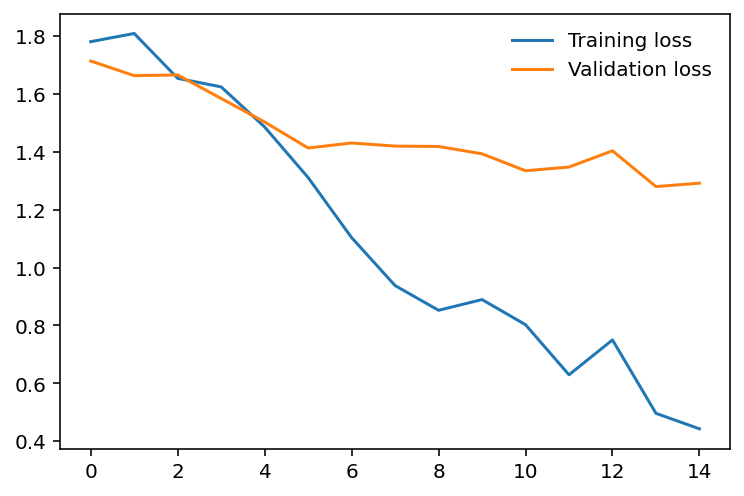

In [19]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [20]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('CNN_model.pt'))

<All keys matched successfully>

In [21]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(number_of_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.449037

Test Accuracy of     0: 44% (28/63)
Test Accuracy of     1: 56% (21/37)
Test Accuracy of     2: 50% (23/46)
Test Accuracy of     3: 83% (30/36)
Test Accuracy of     4: 23% ( 4/17)
Test Accuracy of     5: 45% (18/40)

Test Accuracy (Overall): 51% (124/239)


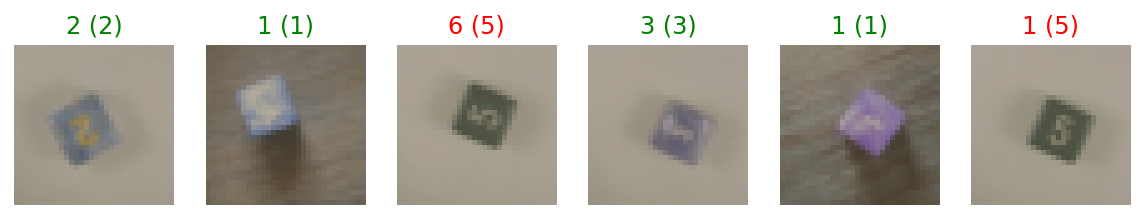

In [22]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

fig, axes = plt.subplots(figsize=(10,display_images), ncols=display_images)
for ii in range(display_images):
    ax = axes[ii]
    DisplayImage(images[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item() + 1), str(labels[ii].item() + 1)),
                 color=("green" if preds[ii]==labels[ii] else "red")) 

# Transfer Learning

In [ ]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained = True)

number_of_classes = 6;

feature_count = model.fc.in_features
model.fc = nn.Linear(feature_count, number_of_classes)

if train_on_gpu:
  model.cuda()

print(model)

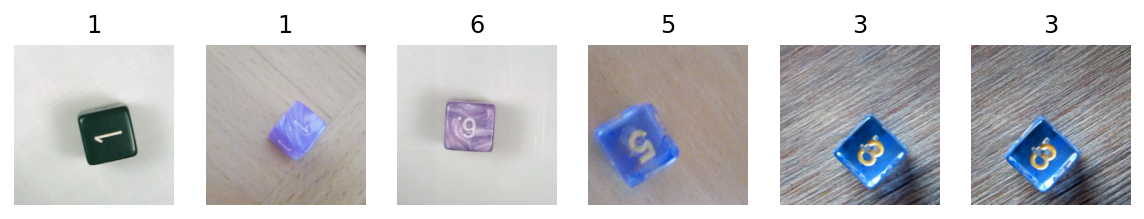

In [24]:
data_dir = 'd6'

batch_size = 6

image_res = 224

display_images = 6

if(display_images > batch_size):
  display_images = batch_size

#train transforms
#trainTransform = transforms.Compose([
#                                     transforms.Resize(image_res + 2),
#                                     transforms.RandomRotation(5),
#                                     transforms.CenterCrop(224),
#                                     transforms.RandomHorizontalFlip(),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.Resize(image_res),
                                transforms.CenterCrop(image_res),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

test_data  = datasets.ImageFolder(data_dir + '/test', transform=transform)
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data   = datasets.ImageFolder(data_dir + '/validate', transform=transform)

test_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)

data_iter = iter(train_loader)
images, labels = next(data_iter)

#print(labels.shape)

fig, axes = plt.subplots(figsize=(10,display_images), ncols=display_images)
for ii in range(display_images):
    ax = axes[ii]
    DisplayImage(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item() + 1)) 

In [25]:
import torch.optim as optim

learning_rate = 0.001;

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), learning_rate)

In [26]:
epochs = 15

valid_loss_min = np.Inf

train_losses, val_losses = [], []

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in val_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'TransferLearning.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/AI/TransferLearning.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.871725 	Validation Loss: 8.231695
Validation loss decreased (inf --> 8.231695).  Saving model ...
Epoch: 2 	Training Loss: 1.385265 	Validation Loss: 6.885016
Validation loss decreased (8.231695 --> 6.885016).  Saving model ...
Epoch: 3 	Training Loss: 1.019525 	Validation Loss: 0.831161
Validation loss decreased (6.885016 --> 0.831161).  Saving model ...
Epoch: 4 	Training Loss: 0.652493 	Validation Loss: 2.195324
Epoch: 5 	Training Loss: 0.900075 	Validation Loss: 0.763846
Validation loss decreased (0.831161 --> 0.763846).  Saving model ...
Epoch: 6 	Training Loss: 0.673045 	Validation Loss: 0.908894
Epoch: 7 	Training Loss: 0.341350 	Validation Loss: 0.807394
Epoch: 8 	Training Loss: 0.349032 	Validation Loss: 0.845976
Epoch: 9 	Training Loss: 0.197656 	Validation Loss: 0.480739
Validation loss decreased (0.763846 --> 0.480739).  Saving model ...
Epoch: 10 	Training Loss: 0.345345 	Validation Loss: 0.934495
Epoch: 11 	Training Loss: 0.598982 	Validation Lo

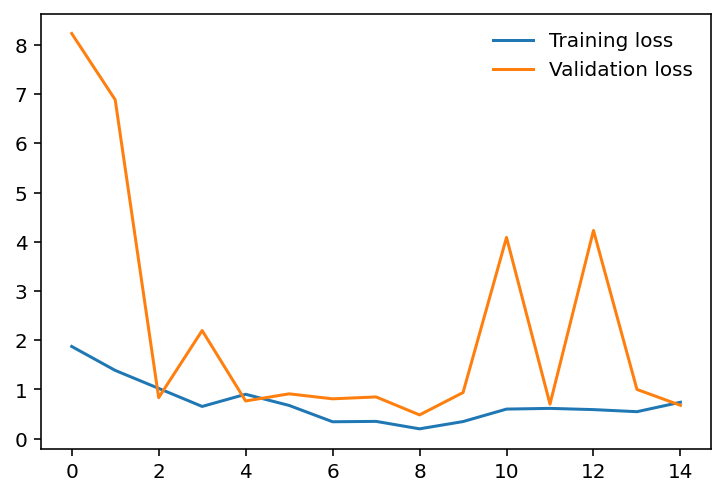

In [27]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [28]:
model.load_state_dict(torch.load('TransferLearning.pt'))

<All keys matched successfully>

In [29]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(number_of_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i + 1), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.286679

Test Accuracy of     1: 100% (63/63)
Test Accuracy of     2: 86% (32/37)
Test Accuracy of     3: 97% (45/46)
Test Accuracy of     4: 86% (31/36)
Test Accuracy of     5: 88% (15/17)
Test Accuracy of     6: 82% (33/40)

Test Accuracy (Overall): 91% (219/239)


#Class Activation Maps (SmoothGradCAM++)

In [30]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

Cloning into 'SmoothGradCAMplusplus'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 47 (delta 13), reused 24 (delta 11), pack-reused 20
Unpacking objects: 100% (47/47), done.


In [31]:
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [32]:
import cam

In [33]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

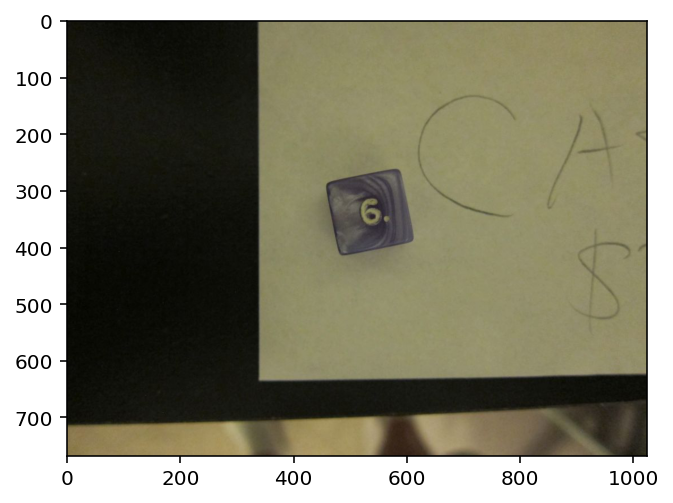

In [34]:
# from ImageNet
image = mpimg.imread('/content/d6/test/6/IMG_4854.JPG')
imshow(image)

In [35]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [36]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:126: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [ ]:
model = models.resnet18(pretrained=True)
model.eval()

In [38]:
target_layer = model.layer4[1].conv2

wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

In [39]:
cam, idx = wrapped_model(tensor)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 549	 probability 0.059326596558094025


In [40]:
img = reverse_normalize(tensor)
heatmap = visualize(img, cam)

In [41]:
# save image
save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

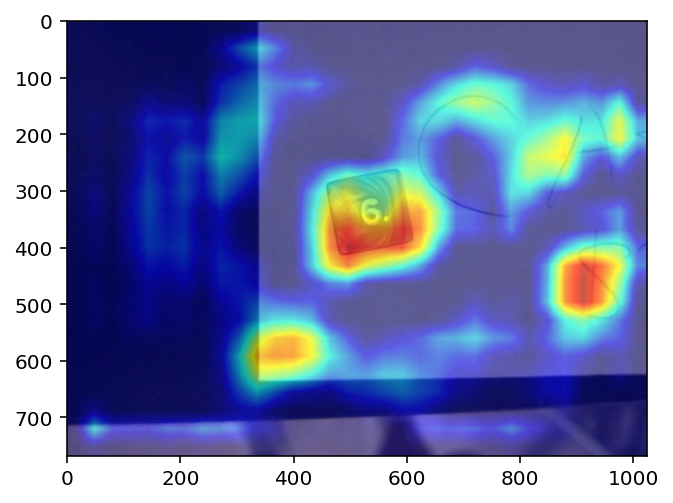

In [42]:
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
imshow(hm)